## Lutfen bu linke git:
https://nbviewer.jupyter.org/github/selimonat/ornament_symmgroups/blob/master/CorrelationAnalysis.ipynb

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/Users/sonat/Documents/repos/ornament_symmgroups/.env/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [11]:
df = pd.read_excel("./symm_groups.xlsx",index_col=0)
df = df.iloc[:,[0,3,2,1,4]]
df

,Andalusia,Armenian,Eastern Roman,ME Arabs,Seljuks
p1,0.00,0.8,14.04,0.00,0.27
p1m1,0.00,4.9,9.65,0.00,0.00
p1g1,0.00,0.0,0.88,0.00,0.00
c1m1,0.00,2.4,4.39,0.00,0.55
p211,0.00,0.0,2.63,0.00,1.10
p2mm,2.88,5.7,9.65,5.75,8.79
p2mg,0.00,0.8,5.26,0.44,0.82
p2gg,0.00,0.8,0.88,0.00,0.55
c2mm,1.92,1.6,3.51,15.93,8.52
p3,0.96,0.8,0.00,0.00,0.82


# Histograms

In [6]:
cols

['Andalusia', 'Armenian', 'ME Arabs', 'Eastern Roman', 'Seljuks']

<IPython.core.display.Javascript object>


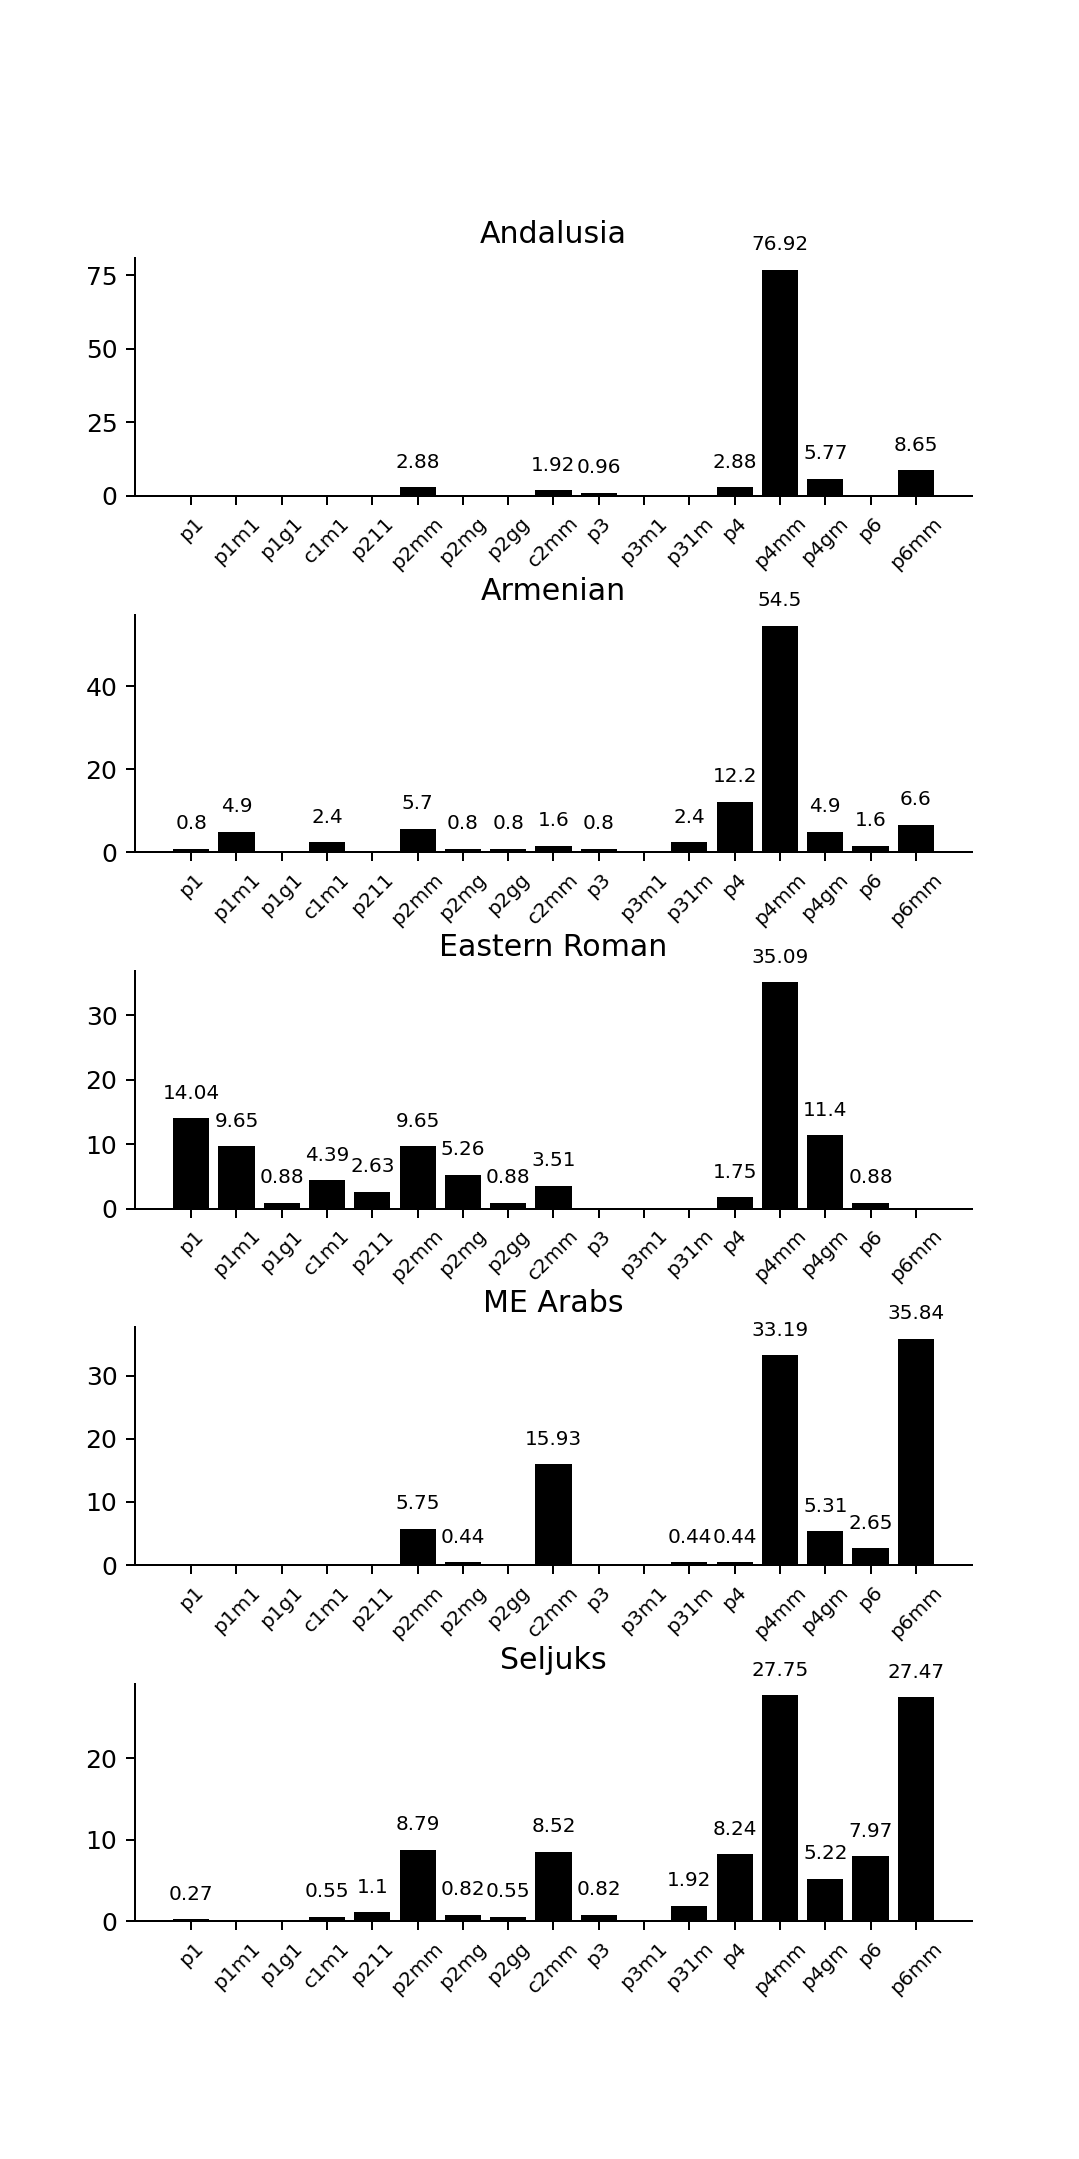

In [12]:
%matplotlib notebook
fig, ax = plt.subplots(5,1,figsize=(6,12))
cols = df.columns.to_list() 
for i in [0,1,2,3,4]:
    ax[i].bar(range(0,17),df[cols[i]],color='k')
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xticklabels(df.index.to_list(),rotation=45,fontsize=8)
    ax[i].set_xticks(np.arange(df.shape[0]))
    for p in ax[i].patches:
        if np.ceil(p.get_height()) != 0:
            ax[i].annotate(np.round(p.get_height(),decimals=2),(p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',fontsize=8)
    ax[i].set_title(cols[i])
plt.subplots_adjust(hspace=.5)

# Correlation

<IPython.core.display.Javascript object>


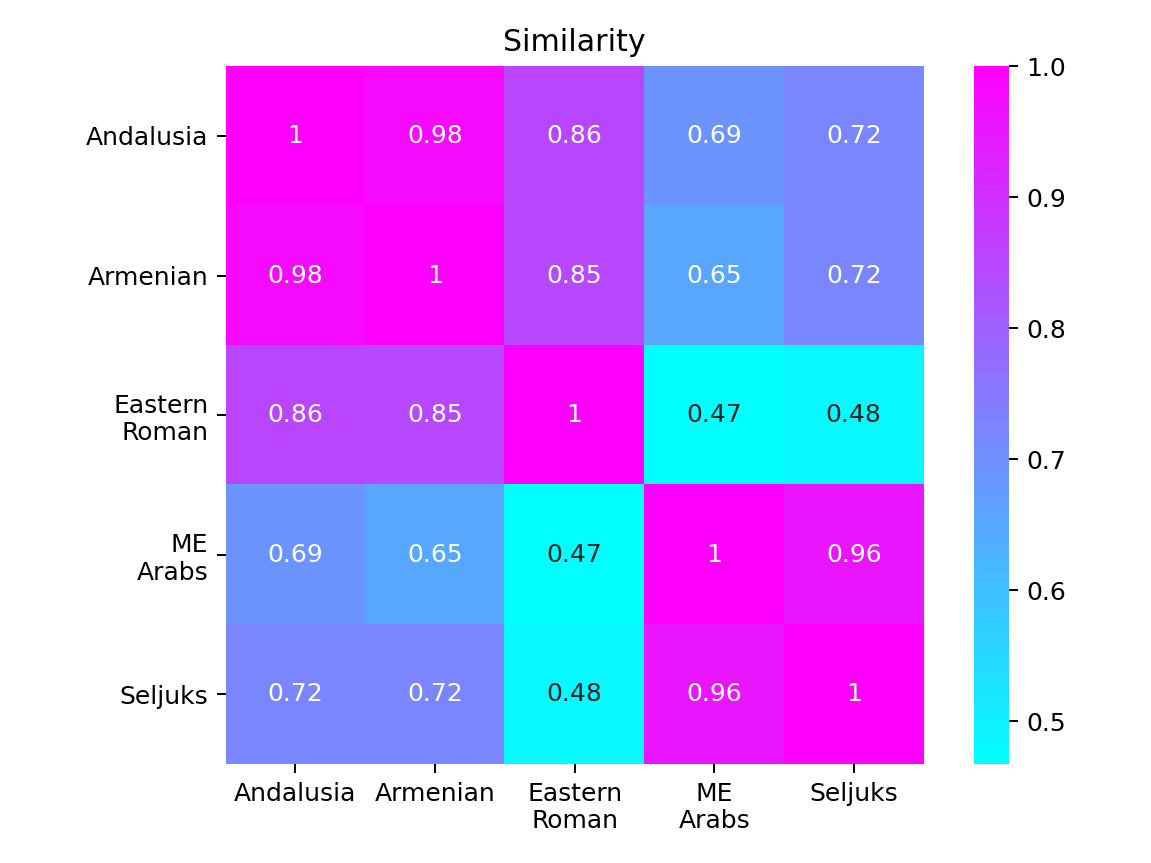

In [13]:
# calculate the correlation matrix
corr = df.corr()
# plot the heatmap
fig = plt.figure()
ax = fig.add_subplot(111, aspect=1)
sns.heatmap(corr, 
        xticklabels=corr.columns.str.replace(' ','\n'),
        yticklabels=corr.columns.str.replace(' ','\n'),
        cmap='cool',
        ax=ax,
        annot=corr.values)
ax.set_title('Similarity')
plt.tight_layout()
#biraz deli bir renk oldu ama simdilik kalsin.

# Geographical Distance

In [14]:
#bunlari medeniyetlerin baskenti olarak aldim.
capitals = ['Granada','Yerevan','Venice','Cairo','Konya']
# capitals = ['Paris','Madrid','Rome','Berlin']

In [15]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

geolocator = Nominatim(user_agent="bla")
Distance = np.zeros((len(capitals),len(capitals)))
for i,c1 in enumerate(capitals):
    for j,c2 in enumerate(capitals):
        l1 = geolocator.geocode(c1)
        l2 = geolocator.geocode(c2)
        d = geodesic(l1.point, l2.point).km
        Distance[i,j] = d

In [16]:
Distance

array([[    0.        , 10484.83140405,  7812.8250988 ,  9624.96129223,
         9554.35066422],
       [10484.83140405,     0.        ,  2677.00043244,  1647.50941825,
         1071.64166835],
       [ 7812.8250988 ,  2677.00043244,     0.        ,  2374.52788161,
         1869.86173816],
       [ 9624.96129223,  1647.50941825,  2374.52788161,     0.        ,
          875.28216742],
       [ 9554.35066422,  1071.64166835,  1869.86173816,   875.28216742,
            0.        ]])

<IPython.core.display.Javascript object>


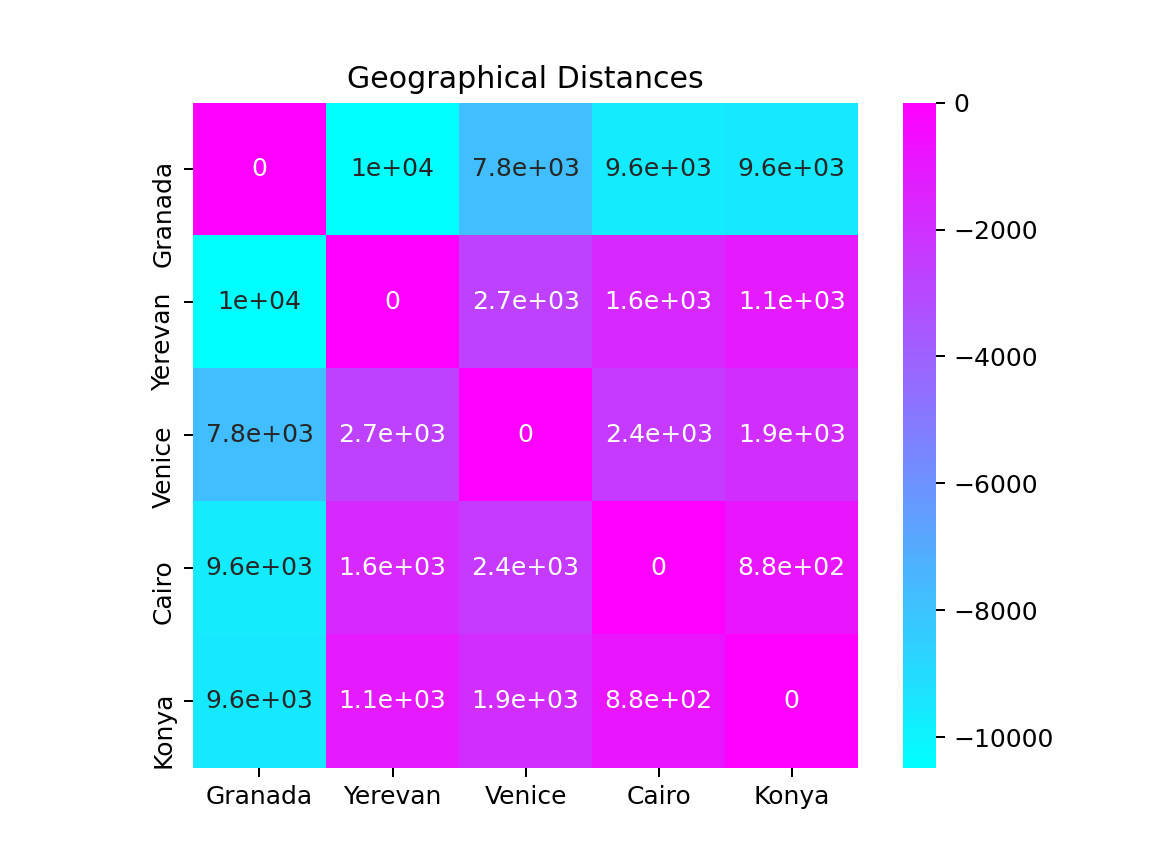

Text(0.5, 1.0, 'Geographical Distances')

In [17]:
corr = Distance
fig = plt.figure()
ax = fig.add_subplot(111, aspect=1)
sns.heatmap(-corr, 
        xticklabels=capitals,
        yticklabels=capitals,
        cmap='cool',
        ax=ax,
        annot=Distance,)
ax.set_title('Geographical Distances')

# MDS Analysis

## MDS analysis takes as input a distance matrix (for example a correlation matrix) and aims to recovers the coordinates that could have potentially generated these dissimilarities.


## The first MDS analysis is done using the geographical distance matrix (as a sanity check). If the algorithm works correctly, MDS should recover the geographical positions of these cities on 2-d, like in a map.

<IPython.core.display.Javascript object>


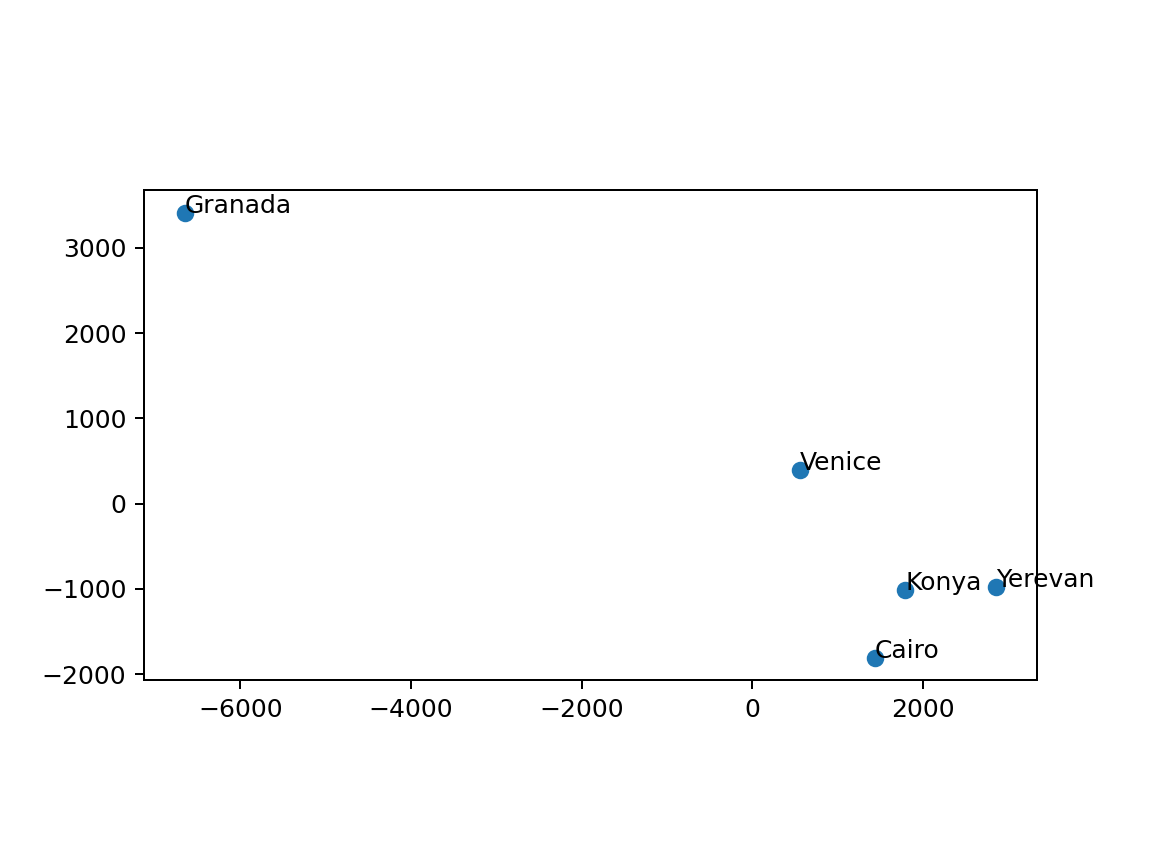

In [18]:
# MDS on geographical distances
from sklearn.datasets import load_digits
from sklearn import manifold

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=1, dissimilarity="precomputed", n_jobs=1)

pos = mds.fit(Distance).embedding_

fig = plt.figure()
ax = fig.add_subplot(111, aspect=1)
ax.plot(-pos[:,0],pos[:,1],'o')

for i, txt in enumerate(capitals):
    ax.annotate(txt, (-pos[i,0], pos[i,1]))
    
# I would say it works. Let's do the MDS with symmetri distances

<IPython.core.display.Javascript object>


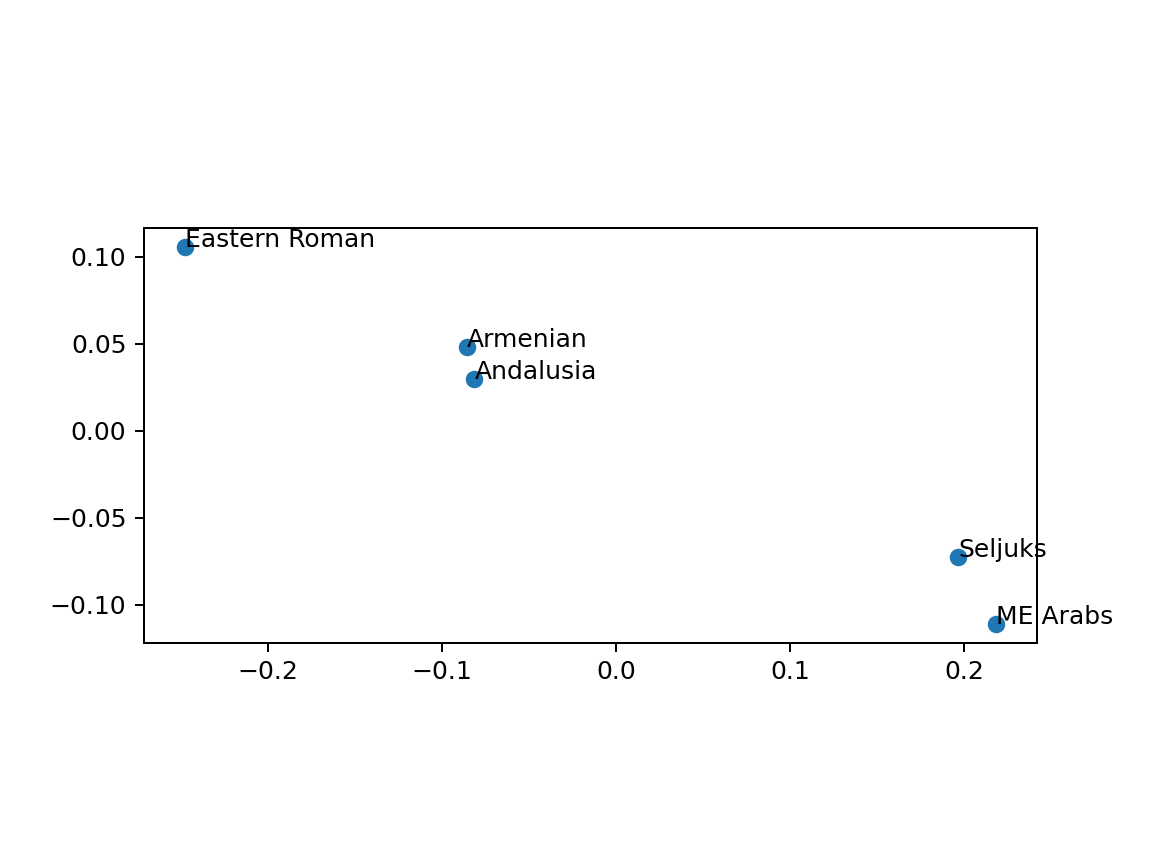

In [19]:
# MDS on symmetry similarities.
corr = df.corr()
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=1, dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(1-corr).embedding_
fig = plt.figure()
ax  = fig.add_subplot(111, aspect=1)
ax.plot(-pos[:,0],pos[:,1],'o')

for i, txt in enumerate(df.columns):
    ax.annotate(txt, (-pos[i,0], pos[i,1]))
    

## simdi yukarida gordugumuz noktalari bize MDS analizi veriyor. 

## Bizim yukaridaki correlation matrisini input olarak aliyor ve output olarak da 4 tane yeni koordinat veriyor. Bu koordinatları da öyle bir seciyor ki, noktalarin arasindaki uzakliklar correlation matrisindeki uzakliklara orantili oluyor. Yani onun icin Armenia nokta taaa en uzaklarda kaliyor. Araplarla, Selcuklarda birbirlerine iki tane yakin nokta olarak duruyorlar, cunku birbirlerine cok benziyorlar.

## Yani, MDS oyle yeni birsey vermiyor bize, sadece korrelasyon matrisinden zar zor okuyabilecegimiz bir bilgiyi, bize gorsel olarak hemen anlamamizi sagliyor, bilgileri yeni bir representasyon haline sokarak. Yok ben MDS'e gerek kalmadan direkt correlasyon matrisinden herseyi cok kolayca gorebiliyorum dersen, MDS'i cikartiriz makaleden. Yok kalsin dersen, ben yazmaya baslarim o bahsettigimiz iki paragrafi.

## Asil bu MDS metodunun faydasini 4 tane medeniyetle degil de, daha cok medeniyetimiz olsaydi daha iyi anlardik. Cunku o zaman, mesela 12 x 12 'lik bir korelasyon matrisine bakmak iskence haline donusuyor (en azindan). MDS sayesinde kim kimin yaninda, kim uzakta, kimler kumelenmis bunlar hemen goruluyor.

## Onun icin bence istersen, biz 4 tane medeniyetle basliyalim paper'a, ama ilerleyen chapterlarda daha cok medeniyet ekliyebiliriz. Yani bu 4 medeniyeting sub-grouplarina bakabiliriz.

# Haritalar

In [21]:
df = pd.read_excel("./GeoList.xlsx",index_col=0)
df = df.reset_index(drop=True)
df

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,ME Arabs,Eastern Roman,Armenian,Seljuks,NaN,NaN
1,Bagdat,Venice,Yerevan,"Birgi, Turkey",NaN,NaN
2,Cairo,NaN,NaN,"Akhan, Turkey",NaN,NaN
3,Damascus,NaN,NaN,"Egridir, Turkey",NaN,NaN
4,Aleppo,NaN,NaN,"Incir han, Turkey",NaN,NaN
...,...,...,...,...,...,...
80,NaN,NaN,NaN,"tatvan, Turkey",NaN,NaN
81,NaN,NaN,NaN,"horosan, Turkey",NaN,NaN
82,NaN,NaN,NaN,"asagi soylemez koy, Turkey",NaN,NaN
83,NaN,NaN,NaN,"van, Turkey",NaN,NaN


In [22]:
def name_to_coor(name):
    if name is np.nan:
        lat,lon = (None,None)
        return lat,lon
    geolocator = Nominatim(user_agent="bla",timeout=10)
    location = geolocator.geocode(name)
    if not location is None:
        lat,lon = location.latitude,location.longitude
    else:
        lat,lon = None,None
    return lat,lon

colname = "Seljuks"
df[colname + "_coor_lat"],df[colname + "_coor_long"] = zip(*df[colname].apply(name_to_coor))
colname = "Eastern Roman"
df[colname + "_coor_lat"],df[colname + "_coor_long"] = zip(*df[colname].apply(name_to_coor))

KeyError: 'Seljuks'

In [240]:
import folium
import pandas as pd

#create a map
center_lat = df["Seljuks_coor_lat"].median()
center_lon = df["Seljuks_coor_long"].median()
this_map = folium.Map(prefer_canvas=True,location=[center_lat,center_lon],zoom_start = 4)
folium.TileLayer('stamenwatercolor').add_to(this_map)

def plotDot(lat,lon,color):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    
    for lat_,lon_ in zip(lat,lon):
        if not lat_ is None:
            folium.CircleMarker(location=[lat_,lon_],
                            radius=7,
                            weight=1,
                            color=color,
                            fill=True).add_to(this_map)

#use df.apply(,axis=1) to "iterate" through every row in your dataframe
plotDot(df["Seljuks_coor_lat"],df["Seljuks_coor_long"],color='red')
plotDot(df["Eastern Roman_coor_lat"],df["Eastern Roman_coor_long"],color='green')


this_map

# Kirmizi: Selcuklar
# Yesil: Eastern Roman


# Time Diagram

In [264]:
next = 50
thick = 30
df = pd.DataFrame.from_dict({"Armenia" : [0,800,0+thick,1200],
                             "Seljuks":[0+next,1200,0+next+thick,1500],
                             "Eastern Roman" : [0+next*2,800,0+next*2+thick,1500],
                             "Moslem Arabs": [0+next*3,900,0+next*3+thick,1200]})
df

,Armenia,Seljuks,Eastern Roman,Moslem Arabs
0,0,50,100,150
1,800,1200,800,900
2,30,80,130,180
3,1200,1500,1500,1200


<IPython.core.display.Javascript object>


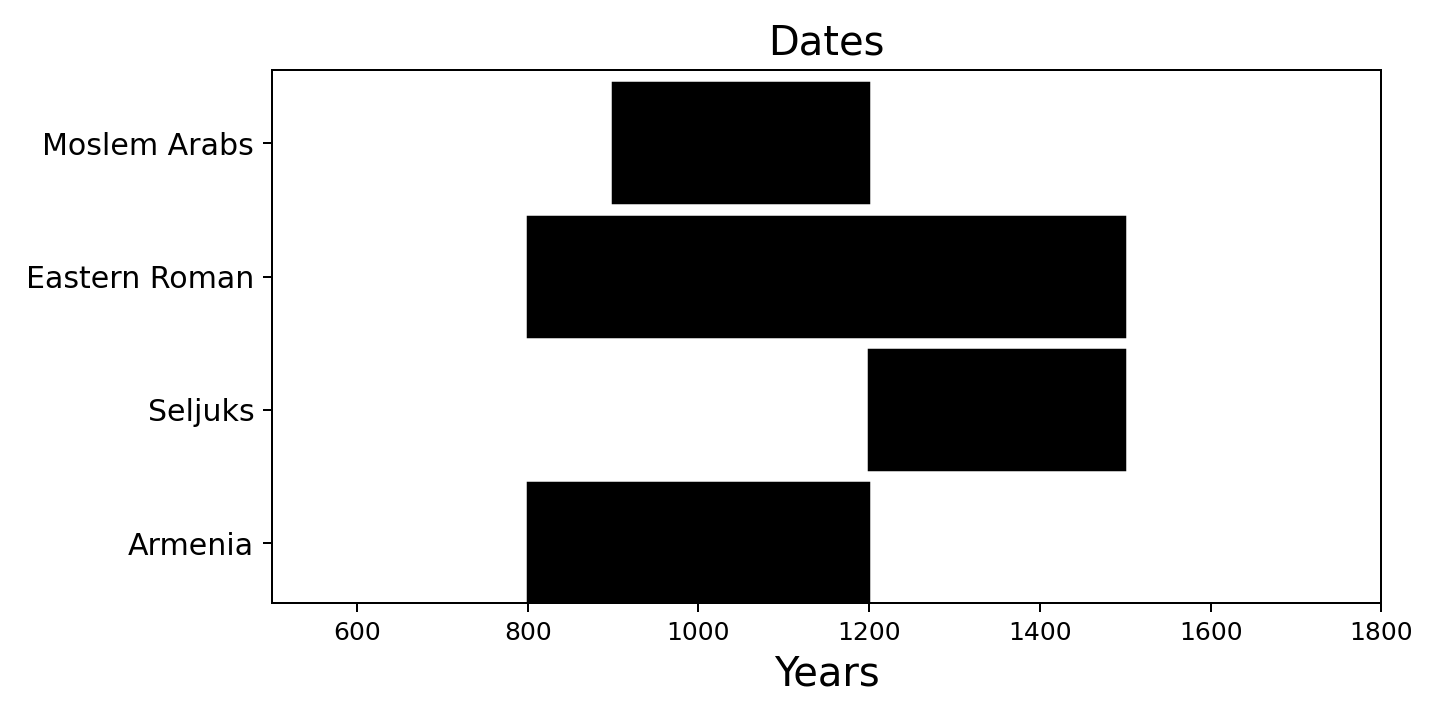

[   0  800   30 1200]
[  50 1200   80 1500]
[ 100  800  130 1500]
[ 150  900  180 1200]


In [296]:
import matplotlib.patches as patches
fig,ax = plt.subplots(1,figsize=(8,4))
# Create a Rectangle patch
for cols in df.columns:
    val = df[cols].values
    print(val)
    rect = patches.Rectangle((val[1],val[0]),val[3]-val[1],45,linewidth=1,edgecolor='k',facecolor='k')
    ax.add_patch(rect)


plt.show()
# plt.tight_layout()
ax.set_xlim(500,1800)
ax.set_ylim(0,200)
ax.set_yticks(np.array([0,50,100,150])+22.5)
ax.set_yticklabels(df.columns,fontsize=12)
ax.set_xlabel('Years',fontsize=16)
ax.set_title('Dates',fontsize=16)
plt.tight_layout()
